<a href="https://colab.research.google.com/github/robinjacobroy/Pix2Pix_image_enhancement/blob/main/pix2pix_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#training data prepration


In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (337 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!mkdir train

In [ ]:
from pdf2image import convert_from_path
from  random import randint
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage.util import random_noise

from skimage.util import img_as_ubyte

In [ ]:
def add_pepper(img):
  row,col,ch = img.shape
  s_vs_p = 0
  amount = np.random.choice(np.arange(0.01,0.5,.01),1)[0]
  out = np.copy(img)
  num_pepper = np.ceil(amount* img.size)
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
  out[coords] = 0
  return out#cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
  #cv2_imshow(out)

In [ ]:
pages = convert_from_path('a-whirlwind-tour-of-python.pdf', 200)
for num, page in enumerate(pages):
    image = np.array(page)

    top = image[:image.shape[0]//2,:,:]
    bottom = image[image.shape[0]//2:,:,:]

    mask1 = np.repeat(np.tile(np.linspace(1, 0, top.shape[1]), (top.shape[0], 1))[:, :, np.newaxis], 3, axis=2)
    mask2 = np.repeat(np.tile(np.linspace(0, 1, bottom.shape[1]), (bottom.shape[0], 1))[:, :, np.newaxis], 3, axis=2)

    f_half = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
    b_half = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)

    dark_im1 = cv2.cvtColor(cv2.convertScaleAbs(f_half, alpha=.1*randint(1,15), beta=randint(2,20)), cv2.COLOR_GRAY2BGR)
    dark_im2 = cv2.cvtColor(cv2.convertScaleAbs(b_half, alpha= 0.1*randint(1,15), beta=randint(2,20)), cv2.COLOR_GRAY2BGR)

    pepper1 = add_pepper(dark_im1)
    pepper2 = add_pepper(dark_im2)

    dark_im1 = cv2.cvtColor(np.uint8(pepper1 * mask1 ), cv2.COLOR_BGR2GRAY)
    dark_im2 = cv2.cvtColor(np.uint8(pepper2 * mask2 ), cv2.COLOR_BGR2GRAY)

    t_data1 = cv2.resize(cv2.hconcat([dark_im1, f_half]),(1024,512))
    t_data2 = cv2.resize(cv2.hconcat([dark_im2, b_half]),(1024,512))

    cv2.imwrite(f'train/out_{num}.png', t_data1)
    cv2.imwrite(f'train/out_{num}_1.png', t_data2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [ ]:
!rm -rf './train/.ipynb_checkpoints'

## pix2pix data creation

In [ ]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(512,1024)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :512], pixels[:, 512:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = './train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'imgs_512.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (196, 512, 512, 3) (196, 512, 512, 3)
Saved dataset:  imgs_512.npz


Loaded:  (196, 512, 512, 3) (196, 512, 512, 3)


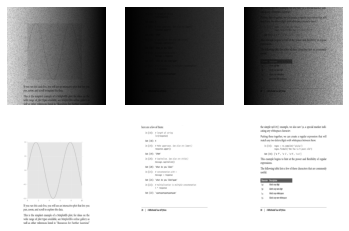

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('imgs_512.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	#pyplot.figure(figsize = (20,10))
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):

	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	#pyplot.figure(figsize = (20,10))
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# example of pix2pix gan for image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
  # define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
image_shape = 512, 512,3
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


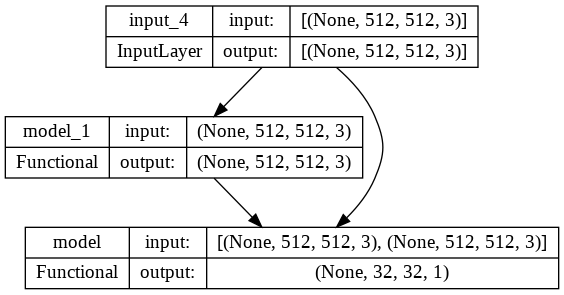

In [ ]:
from tensorflow import keras
keras.utils.plot_model(
    gan_model,
    to_file='model.png',
    show_shapes=True)

In [ ]:
# example of pix2pix gan for image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		#pyplot.figure(figsize=(20,20))
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		#pyplot.figure(figsize=(20,20))
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		#pyplot.figure(figsize=(20,20))
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('imgs_512.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>14604, d1[0.237] d2[0.316] g[3.447]
>14605, d1[0.247] d2[0.366] g[3.018]
>14606, d1[0.298] d2[0.316] g[3.054]
>14607, d1[0.276] d2[0.284] g[2.622]
>14608, d1[0.286] d2[0.333] g[2.659]
>14609, d1[0.291] d2[0.324] g[2.499]
>14610, d1[0.238] d2[0.258] g[3.270]
>14611, d1[0.281] d2[0.321] g[2.786]
>14612, d1[0.273] d2[0.264] g[3.413]
>14613, d1[0.313] d2[0.307] g[1.003]
>14614, d1[0.387] d2[0.556] g[2.007]
>14615, d1[0.262] d2[0.427] g[3.044]
>14616, d1[0.339] d2[0.335] g[2.888]
>14617, d1[0.357] d2[0.348] g[2.293]
>14618, d1[0.336] d2[0.392] g[1.570]
>14619, d1[0.327] d2[0.415] g[1.851]
>14620, d1[0.295] d2[0.331] g[3.065]
>14621, d1[0.297] d2[0.367] g[2.912]
>14622, d1[0.263] d2[0.321] g[3.569]
>14623, d1[0.362] d2[0.336] g[2.141]
>14624, d1[0.322] d2[0.323] g[2.701]
>14625, d1[0.380] d2[0.354] g[1.164]
>14626, d1[0.281] d2[0.392] g[2.507]
>14627, d1[0.284] d2[0.296] g[2.169]
>14628, d1[0.350] d2[0.324] g[2.347]
>14629, d1[0.334] d2[0.3

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/pix2pix'

Mounted at /gdrive
/gdrive/My Drive/pix2pix


In [ ]:
!unzip User_data.zip

Archive:  User_data.zip
  inflating: User_data/00a1e23e-f349-4571-b166-415fc17598dd.jpg  
  inflating: User_data/02e51e78-3148-4294-9589-bfe41d9a0835.jpg  
  inflating: User_data/035f6e1f-3f0b-4469-8371-1a7d172062a4.jpg  
  inflating: User_data/0459be62-64f1-49e3-be56-624a24e75950.jpg  
  inflating: User_data/045bf1cb-a209-4ab4-9700-27a6ff238f7f.jpg  
  inflating: User_data/05b226df-3975-49e9-8814-e54fffb87961.jpg  
  inflating: User_data/0b00ebdc-2730-4165-9859-a07d2c839b0a.jpg  
  inflating: User_data/0b303cd9-b92f-4c23-a8e8-6a5a19235739.jpg  
  inflating: User_data/0ebc9159-db04-4a29-8a6c-3ae70c770bc0.jpg  
  inflating: User_data/0fe381f5-1b83-4758-b68d-3c97c2699bbf.jpg  
  inflating: User_data/13eb5bfe-55c1-4618-b5e9-f903761f8c0a.jpg  
  inflating: User_data/178b2b7d-f4cd-49e1-893c-371fc9f6112c.jpg  
  inflating: User_data/1b0ab55c-a7d2-4701-acd0-a033deac363f.jpg  
  inflating: User_data/2205c328-351d-4f00-8d00-f32f03d28438.jpg  
  inflating: User_data/258ab179-cdb8-4767-9d25-de972

In [ ]:
# example of loading a pix2pix model and using it for one-off image translation
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
import glob
import cv2

# load an image
def load_image(filename, size=(512,512)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

# load source image

for fln in glob.glob("User_data/*.jpg"):
  imm = cv2.imread(fln)
  sh = imm.shape[:2][1],imm.shape[:2][0]
  print(sh)
  src_image = load_image(fln)
  print('Loaded', src_image.shape)

  model = load_model("model_003920.h5")
  # generate image from source
  gen_image = model.predict(src_image)
  # scale from [-1,1] to [0,1]
  gen_image = (gen_image + 1) / 2.0
  name = fln.rpartition("/")[-1]
  image = cv2.resize(gen_image[0], (sh))
  pyplot.imsave(f"output/{name}",image)
  # plot the image
  #pyplot.imshow(gen_image[0])
  #pyplot.axis('off')
  #pyplot.show()
"""
src_image = load_image('1. input.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('model_003920.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()
"""

(576, 397)
Loaded (1, 512, 512, 3)
(692, 345)
Loaded (1, 512, 512, 3)
(1430, 980)
Loaded (1, 512, 512, 3)
(639, 84)
Loaded (1, 512, 512, 3)
(613, 123)
Loaded (1, 512, 512, 3)
(984, 500)
Loaded (1, 512, 512, 3)
(380, 204)
Loaded (1, 512, 512, 3)
(1872, 242)
Loaded (1, 512, 512, 3)
(809, 285)
Loaded (1, 512, 512, 3)
(2000, 659)
Loaded (1, 512, 512, 3)
(576, 84)
Loaded (1, 512, 512, 3)
(525, 218)
Loaded (1, 512, 512, 3)
(403, 302)
Loaded (1, 512, 512, 3)
(576, 106)
Loaded (1, 512, 512, 3)
(1040, 401)
Loaded (1, 512, 512, 3)
(1024, 220)
Loaded (1, 512, 512, 3)
(1248, 575)
Loaded (1, 512, 512, 3)
(880, 1532)
Loaded (1, 512, 512, 3)
(919, 256)
Loaded (1, 512, 512, 3)
(1664, 536)
Loaded (1, 512, 512, 3)
(1642, 380)
Loaded (1, 512, 512, 3)
(972, 458)
Loaded (1, 512, 512, 3)
(1057, 1084)
Loaded (1, 512, 512, 3)
(991, 477)
Loaded (1, 512, 512, 3)
(1248, 726)
Loaded (1, 512, 512, 3)
(1306, 980)
Loaded (1, 512, 512, 3)
(320, 91)
Loaded (1, 512, 512, 3)
(576, 132)
Loaded (1, 512, 512, 3)
(1317, 158

"\nsrc_image = load_image('1. input.jpg')\nprint('Loaded', src_image.shape)\n# load model\nmodel = load_model('model_003920.h5')\n# generate image from source\ngen_image = model.predict(src_image)\n# scale from [-1,1] to [0,1]\ngen_image = (gen_image + 1) / 2.0\n# plot the image\npyplot.imshow(gen_image[0])\npyplot.axis('off')\npyplot.show()\n"

In [ ]:
imm.shape[:2][1],imm.shape[:2][0]

(680, 175)

In [ ]:
pyplot.imsave("output1.png",gen_image[0])

In [ ]:
y = {num: val for num,val in enumerate(x)}

In [ ]:
y

{0: [1, 2, 3], 1: [2, 3, 4, 5], 2: [7, 7, 7, 7]}